In [1]:
import torchvision.models as models
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm, trange
from copy import deepcopy
from sklearn.model_selection import train_test_split
import numpy as np


generator = torch.Generator().manual_seed(42)

In [2]:
from PIL import Image
img = Image.open('celeb/A/0.png')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Step 1: Initialize model with the best available weights
weights = models.ResNet34_Weights.DEFAULT
model = models.resnet34(weights=weights).to(device)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms(antialias=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\PC/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 11.6MB/s]


In [5]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        super(TransformDataset, self).__init__()
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
data = ImageFolder('celeb/', transform=preprocess)

In [9]:
generator = torch.Generator().manual_seed(2023)
train_data, val_data, test_data = random_split(dataset=data, lengths=[0.7, 0.15, 0.15], generator=generator)

data_augumentation = transforms.Compose([transforms.RandomRotation((-15, 15))])
train_data = TransformDataset(ConcatDataset(datasets=[train_data for _ in range(1)]), transform=data_augumentation)
print('train:', len(train_data))
print('val:', len(val_data))
print('test:', len(test_data))
print('total dataset:', len(train_data) + len(val_data) + len(test_data))

train: 319
val: 68
test: 68
total dataset: 455


In [10]:
for param in model.parameters():
    param.requires_grad=False

In [11]:
hidden_dims = 1024
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, hidden_dims),
    nn.Dropout(0.5),
    nn.Linear(hidden_dims, 10)

).to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=[param for param in model.parameters() if param.requires_grad], lr=0.001)

In [13]:
def train_model(model, criterion, optimizer, train, val, batch_size=8, epochs=10):
    trainloader = DataLoader(dataset=train, batch_size=batch_size, generator=generator, shuffle=True)
    valloader = DataLoader(dataset=val, batch_size=batch_size, generator=generator, shuffle=True)
    batches_per_epoch = len(trainloader)

    best = {'best_model': None, 'best_acc': 0}
    history = {'train_loss':[], 'train_acc':[], 'val_acc':[]}
    for epoch in range(epochs):
        with trange(batches_per_epoch, unit='batch') as pbar:
            pbar.set_description(f'{epoch + 1} epoch(s)')

            train_loss = 0
            train_acc = 0
            model.train()
            for x, y in trainloader:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device)
                yhat = model(x)
                _, label = torch.max(yhat, dim=-1)
                loss = criterion(yhat, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_acc += (label==y).sum().item()
                pbar.update()

            train_acc = round(train_acc/len(train), 3)
            history['train_loss'].append(loss)
            history['train_acc'].append(train_acc)

            # eval mode
            val_acc = 0
            model.eval()
            for x, y in valloader:
                x, y = x.to(device), y.to(device)
                _, label = torch.max(model(x), dim=-1)
                val_acc += (label==y).sum().item()

            val_acc = round(val_acc/len(val), 3)
            history['val_acc'].append(val_acc)
            if val_acc > best['best_acc']:
                best['best_model'] = deepcopy(model)
                best['best_acc'] = deepcopy(val_acc)

            pbar.set_postfix_str(f'train_loss: {train_loss} train_acc: {train_acc} val_acc: {val_acc}')
    return history, best

In [14]:
history, best = train_model(model, criterion, optimizer, train_data, val_data, batch_size=32, epochs=20)

20 epoch(s): 100%|██████████| 10/10 [00:04<00:00,  2.45batch/s, train_loss: 12.139179229736328 train_acc: 0.602 val_acc: 0.603]


In [15]:
testloader = DataLoader(dataset=test_data, batch_size=len(test_data))
best_model = best['best_model']

acc = 0
for x, y in testloader:
    x, y = x.to(device), y.to(device)

    yhat = best_model(x)
    _, label = torch.max(yhat, dim=-1)
    acc += (label == y).sum().item()

acc = acc/len(test_data)
print('best accuracy:', best['best_acc'])
print('Test accuracy:', acc)

best accuracy: 0.603
Test accuracy: 0.5588235294117647


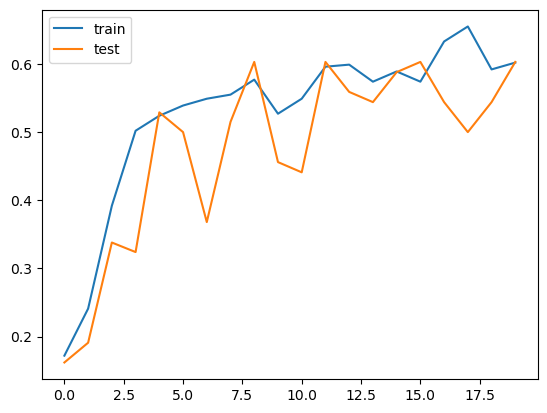

In [16]:
import matplotlib.pylab as plt
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='test')
plt.legend()

Fine Tuning

In [17]:
best_model = best['best_model'] 

In [18]:
def predict(x):
    input_tensor = preprocess(x.to(device))
    input_batch = input_tensor.unsqueeze(0)
    _, label = torch.max(best_model(input_batch), dim=-1)
    return label
best_model.predict = predict

In [19]:
best_model.predict(train_data[0][0])

tensor([2], device='cuda:0')